### Training Using Transfer Learning and TPU

In [1]:
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
from tqdm import tqdm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.1


In [2]:
# NEW on TPU in TensorFlow 24: 
# shorter cross-compatible TPU/GPU/multi-GPU/
# GPU detection code

try: # detect TPUs
#TPU detection
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)

except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() 
    #for GPU or multi-GPU machines
    
    #strategy = tf.distribute.get_strategy() # default strategy that works on
    # CPU and single GPU
    
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
    # for clusters of multi-GPU machines
    
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


# Making Ethnicity Model

### Loading the Model

In [3]:
from keras.applications import MobileNet as OurModel

In [4]:
size_of_input = int(input('What is the size of model input?'))

What is the size of model input? 224


Inspecting Each layer

### Let's freeze all layers except the top X

In [5]:
with strategy.scope():
    #  was designed to work on 224 x 224 pixel input images sizes
    img_rows = size_of_input
    img_cols = size_of_input 

    # Re-loads the model without the top or FC layers
    derived_model = OurModel(weights = 'imagenet', 
                     include_top = False, 
                     input_shape = (img_rows, img_cols, 3))

    # Here we freeze the last 4 layers 
    # Layers are set to trainable as True by default
    for layer in derived_model.layers:
        layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(derived_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

17227776/17225924 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization False
16 ReLU False
17 DepthwiseConv2D False
18 BatchNormalization False
19 ReLU False
20 Conv2D False
21 BatchNormalization False
22 ReLU False
23 ZeroPadding2D False
24 DepthwiseConv2D False
25 BatchNormalization False
26 ReLU False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 DepthwiseConv2D False
31 BatchNormalization False
32 ReLU False
33 Conv2D False
34 BatchNormalization False
35 ReLU False
36 ZeroPadding2D False
37 DepthwiseConv2D False
38 BatchNormalization False
39 ReLU False
40 Conv2D False
41 BatchNormalization False
42 ReLU False
43 DepthwiseConv2D False
44 BatchNormalization F

### Proposed Top Layer (type 2)
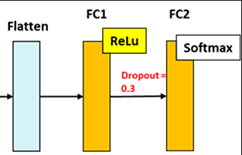

In [6]:
def addTopModel(bottom_model, num_classes, D=size_of_input):
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

## Let's add our FC Head back

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import GlobalAveragePooling2D

In [8]:
with strategy.scope():
    num_classes = int(input('How Many classes?'))

    FC_Head = addTopModel(derived_model, num_classes)

    model = Model(inputs=derived_model.input, outputs=FC_Head)
    
    checkpoint = ModelCheckpoint("./02_SixRace_Woman_Mobilenet_top2_tpu_b.h5",
                                 monitor="val_loss",
                                 mode="min",
                                 save_best_only = True,
                                 verbose=1)

    earlystop = EarlyStopping(monitor = 'val_loss', 
                              min_delta = 0, 
                              patience = 25,
                              verbose = 1,
                              restore_best_weights = True)

    # we put our call backs into a callback list
    callbacks = [earlystop, checkpoint]
    
    # Note we use a very small learning rate 
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = RMSprop(lr = 0.001),
                  metrics = ['accuracy'])

print(model.summary())

How Many classes? 6


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [ ]:
from keras.utils.vis_utils import plot_model
#model
plot_model(model, to_file='ethnicity_mmix_gmix_Mobnet_topv1.png', show_shapes=True, show_layer_names=True)

## Load Dataset

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

DATADIR = '../input/ds-race-mixmask-gensep/Female_Train/'
#path_folder = glob.glob(str(DATADIR)+'*')

CATEGORIES = os.listdir(DATADIR)
CATEGORIES.sort()

#for content in path_folder:
#    CATEGORIES.append(content.split('/')[-1])

IMG_SIZE = size_of_input

training_data_color = []
class_index = []

def build_training_data():
    #count = 0
    for category in tqdm(CATEGORIES):
        path = os.path.join (DATADIR, category) # path to each
        class_num = CATEGORIES.index(category)
        class_index.append(class_num)
        image_address = os.listdir(path)
        image_address.sort()
        for img in image_address:
            try:
                img_array = cv2.imread (os.path.join(path,img))
                new_array = cv2.resize (img_array, (IMG_SIZE,IMG_SIZE))
                training_data_color.append([new_array,class_num])
                
                #if (count %600 == 0):
                #    print('PROGRESS:',round(100*count/6000,2),'%')
                #count +=1
                
            except Exception as e:
                count +=1
                pass

print('Loading...')
build_training_data()
print('Training Data And Labels Are Built!!')

  0%|          | 0/6 [00:00<?, ?it/s]

Loading...


100%|██████████| 6/6 [00:36<00:00,  6.07s/it]

Training Data And Labels Are Built!!


In [10]:
print(CATEGORIES)
print(class_index)

for kk in CATEGORIES:
    print(CATEGORIES.index(kk))

['ASEAN', 'African', 'Arab', 'Caucasian', 'East_Asian', 'South_Asian']
[0, 1, 2, 3, 4, 5]
0
1
2
3
4
5


0


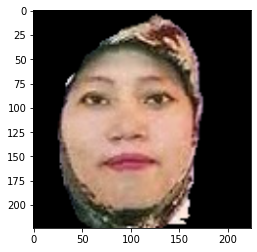

In [10]:
i = 2
print(training_data_color[i][1])
plt.imshow(training_data_color[i][0][:,:,::-1])

0


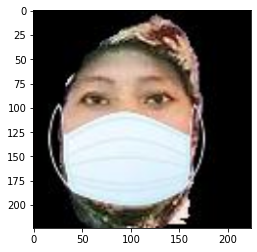

In [11]:
i = 3
print(training_data_color[i][1])
plt.imshow(training_data_color[i][0][:,:,::-1])

In [12]:
# DONT Shuffle
#print('1. Shuffling The Training Data')
#random.shuffle (training_data_color)
print('1. No Shuffling this time')
print('2. Separate Features and Labels')
X_train_color = []
y_train_color = []

for features, labels in training_data_color:
    X_train_color.append(features)
    y_train_color.append (labels)
    
print('3. Convert Them into np.array')
X_train_color = np.array (X_train_color)
y_train_color = np.array (y_train_color)
print('4. Check their size/shape')
print (X_train_color.shape)
print (y_train_color.shape)

1. No Shuffling this time
2. Separate Features and Labels
3. Convert Them into np.array
4. Check their size/shape
(3000, 224, 224, 3)
(3000,)


#### Load Testing Dataset

In [13]:
#create test dataset for colored images
#print('--Loading testing Dataset--')
#print('...wait...')
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

DATADIR = '../input/ds-race-mixmask-gensep/Female_Test/'

testing_data_color = []

def build_testing_data():
    for category in tqdm(CATEGORIES):
        path = os.path.join (DATADIR, category) # path to each
        class_num = CATEGORIES.index(category)
        image_address = os.listdir(path)
        image_address.sort()
        for img in image_address:
            try:
                img_array = cv2.imread (os.path.join(path,img))
                new_array = cv2.resize (img_array, (IMG_SIZE,IMG_SIZE))
                testing_data_color.append([new_array,class_num])
            except Exception as e:
                pass

build_testing_data()
print('Testing Data And Labels Are Built!!')

100%|██████████| 6/6 [00:10<00:00,  1.70s/it]

Testing Data And Labels Are Built!!


In [14]:
print(CATEGORIES)
#print(os.listdir(DATADIR))

for kk in CATEGORIES:
    print(CATEGORIES.index(kk))

['ASEAN', 'African', 'Arab', 'Caucasian', 'East_Asian', 'South_Asian']
0
1
2
3
4
5


### Let's take a look at some of images in this dataset
- Using OpenCV
- Using Matplotlib

4


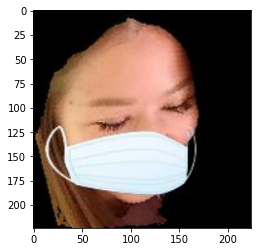

In [15]:
i = 805
print(testing_data_color[i][1])
plt.imshow(testing_data_color[i][0][:,:,::-1])

2


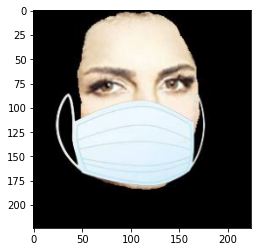

In [16]:
i = 427
print(testing_data_color[i][1])
plt.imshow(testing_data_color[i][0][:,:,::-1])

In [17]:
print('0. Overview of Testing Dataset: ',len(testing_data_color))
#random.shuffle(testing_data_color)
print('1. No Shuffling this time')
X_test_color = [] #feature set
y_test_color = [] # label

for features, labels in testing_data_color:
    X_test_color.append(features)
    y_test_color.append (labels)
    
print('2. Testing Labels and Features Separated')

X_test_color = np.array(X_test_color)
y_test_color = np.array(y_test_color)

print('3. Each Testing Labels and Features Are converted into np.array')

print('4. Overview after type conversion:')
print (X_test_color.shape)
print (y_test_color.shape)

0. Overview of Testing Dataset:  1200
1. No Shuffling this time
2. Testing Labels and Features Separated
3. Each Testing Labels and Features Are converted into np.array
4. Overview after type conversion:
(1200, 224, 224, 3)
(1200,)


## Step 2A: Examine the size and image dimenions

- Check the number of samples, dimenions and whether images are color or grayscale
- We see that our training data consist of 1200 samples of training data, 216 samples of test data
- Our labels are appropriately sized as well
- Our Image dimenions are 224 x 224, with 3 color channels (i.e. they are BGR, so not grayscale channel)

In [18]:
# printing the number of samples in x_train, x_test, y_train, y_test
print("Initial shape or dimensions of x_train", str(X_train_color.shape))

print ("Number of samples in our training data: " + str(len(X_train_color)))
print ("Number of labels in our training data: " + str(len(y_train_color)))
print ("Number of samples in our test data: " + str(len(X_test_color)))
print ("Number of labels in our test data: " + str(len(y_test_color)))
print()
print ("Dimensions of x_train:" + str(X_train_color[0].shape))
print ("Labels in x_train:" + str(y_train_color.shape))
print()
print ("Dimensions of x_test:" + str(X_test_color[0].shape))
print ("Labels in y_test:" + str(y_test_color.shape))

Initial shape or dimensions of x_train (3000, 224, 224, 3)
Number of samples in our training data: 3000
Number of labels in our training data: 3000
Number of samples in our test data: 1200
Number of labels in our test data: 1200

Dimensions of x_train:(224, 224, 3)
Labels in x_train:(3000,)

Dimensions of x_test:(224, 224, 3)
Labels in y_test:(1200,)


### Convert X_train and X_test into Keras format and shape

In [19]:
# Lets store the number of rows and columns
img_rows = X_train_color[0].shape[0]
img_cols = X_train_color[0].shape[1]

# Getting our date in the right 'shape' needed for Keras
# We need to add a 4th dimenion to our date thereby changing our
# Our original image shape of (60000,28,28) to (60000,28,28,1)
X_train_color = X_train_color.reshape(X_train_color.shape[0], img_rows, img_cols, 3)
X_test_color = X_test_color.reshape(X_test_color.shape[0], img_rows, img_cols, 3)

# store the shape of a single image 
input_shape = (img_rows, img_cols, 3)

# change our image type to float32 data type
X_train_color = X_train_color.astype('float32')
X_test_color = X_test_color.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
X_train_color /= 255
X_test_color /= 255

print('X_train_color shape:', X_train_color.shape)
print(X_train_color.shape[0], 'train samples')
print(X_test_color.shape[0], 'test samples')


X_train_color shape: (3000, 224, 224, 3)
3000 train samples
1200 test samples


## One-hot encode the labels of both train and test dataset

In [20]:
import tensorflow as tf
from tensorflow import keras 
from keras.utils import np_utils

# Now we one hot encode outputs
y_train_color = np_utils.to_categorical(y_train_color)
y_test_color = np_utils.to_categorical(y_test_color)

# Let's count the number columns in our hot encoded matrix 
print ("Number of Classes: " + str(y_test_color.shape[1]))

num_classes = y_test_color.shape[1]
num_pixels = X_train_color.shape[1] * X_train_color.shape[2]

Number of Classes: 6


## THEN TRAINING

In [21]:
import timeit
# We start with high epoch
nb_train_samples = X_train_color.shape[0]
nb_validation_samples = X_test_color.shape[0]

EPOCHS = 500
batch_size = 16*strategy.num_replicas_in_sync
#batch_size = 128

start = timeit.default_timer()
print('Training started, with epoch plan: ', EPOCHS)
print('........wait until finish........')

#history = model.fit_generator( <--is deprecated and will be removed in a future version
history = model.fit(
    X_train_color, y_train_color,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = EPOCHS,
    callbacks = callbacks,
    validation_data = (X_test_color, y_test_color),
    validation_steps = nb_validation_samples // batch_size)

stop = timeit.default_timer()
print('--FINISH--')
print('Total time: ',int((stop-start)//60),'minutes',int((stop-start)%60),'seconds')


Training started, with epoch plan:  500
........wait until finish........
Epoch 1/500
23/23 [==============================] - 24s 695ms/step - loss: 56.5412 - accuracy: 0.3023 - val_loss: 1.3647 - val_accuracy: 0.4850

Epoch 00001: val_loss improved from inf to 1.36470, saving model to ./02_SixRace_Woman_Mobilenet_top2_tpu_b.h5
Epoch 2/500
23/23 [==============================] - 1s 56ms/step - loss: 1.3832 - accuracy: 0.5403 - val_loss: 4.9239 - val_accuracy: 0.3375

Epoch 00002: val_loss did not improve from 1.36470
Epoch 3/500
23/23 [==============================] - 1s 54ms/step - loss: 2.3436 - accuracy: 0.4653 - val_loss: 1.3649 - val_accuracy: 0.4758

Epoch 00003: val_loss did not improve from 1.36470
Epoch 4/500
23/23 [==============================] - 1s 52ms/step - loss: 1.1930 - accuracy: 0.6249 - val_loss: 0.9938 - val_accuracy: 0.6208

Epoch 00004: val_loss improved from 1.36470 to 0.99376, saving model to ./02_SixRace_Woman_Mobilenet_top2_tpu_b.h5
Epoch 5/500
23/23 [====

In [22]:
numberOfEpoch = int(input('How many epochs last?__'))
print('Time consumed:',round((stop-start)/numberOfEpoch,2),'second/epoch')
print('Training Speed:',round(numberOfEpoch*60/(stop-start),0),'epochs/minutes')
print('total time (seconds) = ', stop - start)

How many epochs last?__ 32


Time consumed: 2.48 second/epoch
Training Speed: 24.0 epochs/minutes
total time (seconds) =  79.37235556300004


##### Calculate Training and model Performance

--Loss curve after trained by TPU--


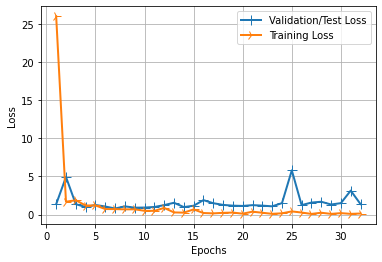

In [23]:
# Plotting our loss charts
import matplotlib.pyplot as plt
print('--Loss curve after trained by TPU--')
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


--Accuracy curve after trained by TPU--


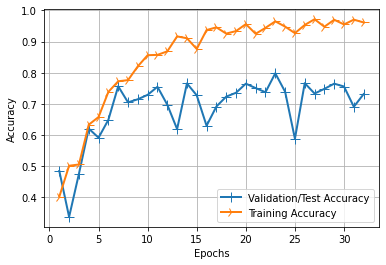

In [24]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history
print('--Accuracy curve after trained by TPU--')
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


In [25]:
#Accuracy and Loss print
score = model.evaluate(X_test_color, y_test_color, verbose=0)
print('Best condition:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Best condition:
Test loss: 0.7971242666244507
Test accuracy: 0.7566666603088379


## Confusion Matrix 

<AxesSubplot:>

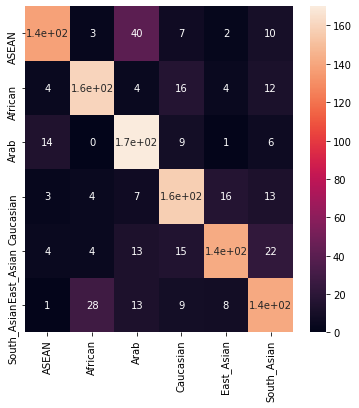

In [26]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


label = tf.argmax(y_test_color, axis = 1)
#prediction1 = model.predict_classes(X_test_color) <-- IF Sequential
prediction1 = np.argmax(model.predict(X_test_color),axis=1) # <-- IF NOT Sequential

matrix = metrics.confusion_matrix(label, prediction1)


# CATEGORIES = 

df_cm = pd.DataFrame(matrix, index = [i for i in CATEGORIES],
                  columns = [i for i in CATEGORIES])
plt.figure(figsize = (6,6))
sn.heatmap(df_cm, annot=True)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print('Classification Report')
#target_names = CATEGORIES
print(classification_report(label, prediction1, target_names=CATEGORIES))

Classification Report
              precision    recall  f1-score   support

       ASEAN       0.84      0.69      0.76       200
     African       0.80      0.80      0.80       200
        Arab       0.69      0.85      0.76       200
   Caucasian       0.74      0.79      0.76       200
  East_Asian       0.82      0.71      0.76       200
 South_Asian       0.69      0.70      0.70       200

    accuracy                           0.76      1200
   macro avg       0.76      0.76      0.76      1200
weighted avg       0.76      0.76      0.76      1200



--Normalized Version of Confusion Matrix--


<AxesSubplot:>

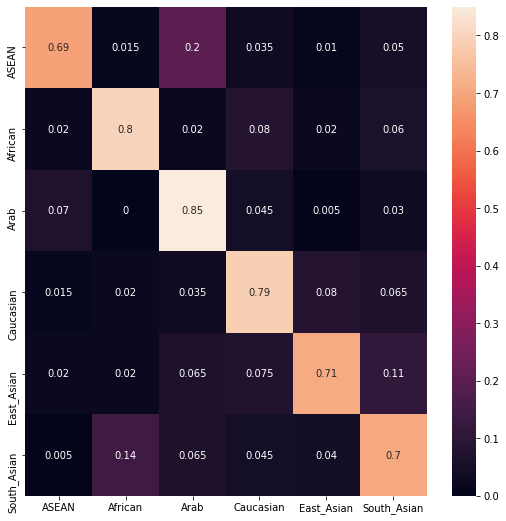

In [28]:
print('--Normalized Version of Confusion Matrix--')

matrix = metrics.confusion_matrix(label, prediction1, normalize='true')

df_cm = pd.DataFrame(matrix, index = [i for i in CATEGORIES],
                  columns = [i for i in CATEGORIES])
plt.figure(figsize = (9,9))
sn.heatmap(df_cm, annot=True)
